### **Dataset**

In this homework, we will use the California Housing Prices from [Kaggle](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv).

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In [34]:
# Imports

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import re
import xgboost as xgb

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
df_initial = pd.read_csv(url)
df_initial.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df_initial.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
df_initial.fillna(0, inplace=True)
df_initial.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### **Preparing the dataset**
For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

In [6]:
df_initial.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [7]:
df = df_initial[(df_initial.ocean_proximity == '<1H OCEAN') | (df_initial.ocean_proximity == 'INLAND')]
df.ocean_proximity.unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

Apply the log tranform to median_house_value.

In [8]:
df.median_house_value.head()

701    431000.0
830    217000.0
859    247600.0
860    283500.0
861    216900.0
Name: median_house_value, dtype: float64

In [9]:
df.loc[ : , 'median_house_value'] = np.log1p(df.median_house_value)
df.median_house_value.head()

701    12.973866
830    12.287657
859    12.419574
860    12.554971
861    12.287196
Name: median_house_value, dtype: float64

Do train/validation/test split with 60%/20%/20% distribution.

Use the train_test_split function and set the random_state parameter to 1.

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

Use DictVectorizer(sparse=True) to turn the dataframe into matrices.

In [11]:
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [12]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

### **Question 1**

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

Which feature is used for splitting the data?
- ocean_proximity
- total_rooms
- latitude
- population

In [13]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [14]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



### **Answer**: ocean_proximity

### **Question 2**

Train a random forest model with these parameters:
- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?
- 0.045
- 0.245
- 0.545
- 0.845

In [15]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [16]:
y_pred = rf.predict(X_val)
np.round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)

0.245

### **Answer**: 0.245

### **Question 3**
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.

Set random_state to 1.

Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?
- 10
- 25
- 50
- 160

In [17]:
n_estimators = list(np.arange(10, 210, 10))
n_estimators

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200]

In [18]:
for elem in n_estimators:
    rf = RandomForestRegressor(n_estimators=elem, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('%3s -> %.5F' % (elem, rmse))

 10 -> 0.24460
 20 -> 0.23780
 30 -> 0.23621
 40 -> 0.23472
 50 -> 0.23458
 60 -> 0.23420
 70 -> 0.23419
 80 -> 0.23439
 90 -> 0.23430
100 -> 0.23413
110 -> 0.23417
120 -> 0.23390
130 -> 0.23380
140 -> 0.23364
150 -> 0.23353
160 -> 0.23331
170 -> 0.23333
180 -> 0.23356
190 -> 0.23384
200 -> 0.23377


### **Answer**: 70

### **Question 4**

Let's select the best max_depth:
- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

What's the best max_depth:
- 10
- 15
- 20
- 25

In [19]:
scores = []

for m in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=m, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        
        scores.append([m, n, score])

df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

In [20]:
df_scores.sort_values('rmse').head()

,max_depth,n_estimators,rmse
76,25,170,0.233400
75,25,160,0.233410
74,25,150,0.233472
73,25,140,0.233573
77,25,180,0.233590


### **Answer**: 25

### **Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:
- Train the model with these parametes:
n_estimators=10,
max_depth=20,
random_state=1,
n_jobs=-1 (optional)
- Get the feature importance information from this model

What's the most important feature (among these 4)?
- total_rooms
- median_income
- total_bedrooms
- longitude

In [21]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [22]:
rf.feature_importances_

array([0.01504314, 0.03006329, 0.10266505, 0.08585341, 0.33548579,
       0.21881985, 0.14745955, 0.02811472, 0.01543366, 0.02106153])

In [23]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values('importance', ascending=False)

,feature,importance
4,median_income,0.335486
5,ocean_proximity=<1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460
2,latitude,0.102665
3,longitude,0.085853
1,housing_median_age,0.030063
7,population,0.028115
9,total_rooms,0.021062
8,total_bedrooms,0.015434
0,households,0.015043


### **Answer**: median_income

### **Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:
1. Install XGBoost
2. Create DMatrix for train and validation
3. Create a watchlist
4. Train a model with these parameters for 100 rounds:

    xgb_params = {'eta': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'nthread': 8, 'seed': 1, 'verbosity': 1}

5. Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?
- 0.3
- 0.1
- Both give equal value

In [58]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [59]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [60]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [61]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [62]:
scores['eta=0.3'] = parse_xgb_output(output)
df_sc_03 = pd.DataFrame(parse_xgb_output(output)).sort_values('val_auc')
df_sc_03.head()

,num_iter,train_auc,val_auc
38,190,0.07833,0.22863
39,195,0.07724,0.22865
34,170,0.08600,0.22871
33,165,0.08802,0.22876
36,180,0.08221,0.22877


In [63]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [64]:
scores['eta=0.1'] = parse_xgb_output(output)
df_sc_01 = pd.DataFrame(parse_xgb_output(output)).sort_values('val_auc')
df_sc_01.head()

,num_iter,train_auc,val_auc
39,195,0.13700,0.22551
40,199,0.13601,0.22559
38,190,0.13814,0.22563
37,185,0.13935,0.22571
36,180,0.14065,0.22584


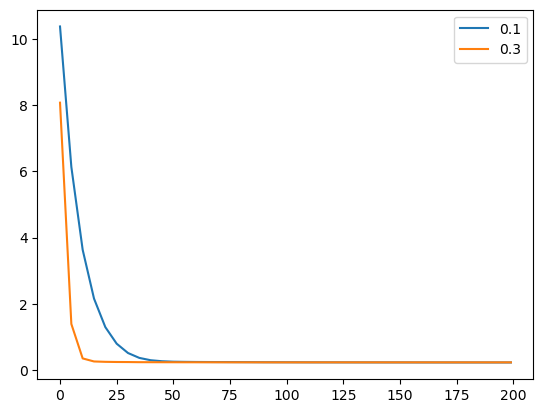

In [65]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.3')
plt.legend()
plt.show()

### **Answer**: Both give equal value (using num_boost_round=200 there is practically no difference)
using num_boost_round=100: eta=0.3 was slightly better, using num_boost_round=200: eta=0.1 was slightly better